# Setup

In [1]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [2]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


# Finding top token-aligned neurons

In [6]:
results = {key: {} for key in [31, 32, 33, 34, 35]}


for n in results.keys():
    n_layer_neurons = model.W_out[n, :, :]
    unembedding = model.W_U
    dot_product = einsum("neuron embed, embed token -> neuron token", n_layer_neurons, unembedding)
    values, indices = torch.max(dot_product, dim=-1)

    num = 5000
    top_values, top_indices = torch.topk(values, k=num)
    neurons_to_find = 10
    neurons_found = 0
    for i in range(num):

        str_token = model.to_string(indices[top_indices[i]])
        if len(str_token) <= 2 or str_token[0] != " ":
            continue
        print(f"L{n}N{top_indices[i]}: {str_token} ({top_values[i]:.2f})")
        results[n][top_indices[i].item()] = [str_token, top_values[i].item()]

        neurons_found += 1
        if neurons_found >= neurons_to_find:
            break

L31N3621:  only (5.47)
L31N364:  number (5.32)
L31N2918:  go (5.09)
L31N4378:  together (5.04)
L31N988:  called (5.02)
L31N2658:  first (4.90)
L31N2692:  used (4.67)
L31N4941:  within (4.50)
L31N2415:  way (4.37)
L31N1407:  out (4.27)
L32N4964:  too (5.54)
L32N2412:  will (5.11)
L32N4282:  right (4.93)
L32N3151:  over (4.80)
L32N1155:  out (4.68)
L32N1386:  once (4.45)
L32N3582:  her (4.26)
L32N4882:  class (4.21)
L32N3477:  use (4.20)
L32N406:  much (4.20)
L33N1202:  so (6.02)
L33N524:  state (5.66)
L33N1582:  RandomRedditor (5.30)
L33N4446:  about (4.55)
L33N204:  following (4.46)
L33N4900:  of (4.32)
L33N2322:  after (4.12)
L33N3278:  around (4.12)
L33N1299:  last (4.08)
L33N52:  by (3.96)
L34N4012:  off (6.54)
L34N4262:  down (5.78)
L34N320:  back (5.68)
L34N5095:  well (5.32)
L34N2599:  there (4.88)
L34N2442:  up (4.46)
L34N4494:  no (4.45)
L34N4199:  after (4.34)
L34N727:  under (4.14)
L34N4410:  as (3.21)
L35N4518:  issue (3.79)
L35N48:  close (3.53)
L35N5014:  won (3.10)
L35N37

In [8]:
unembedding.shape

torch.Size([1280, 50257])

In [65]:
results = {key: {} for key in [31, 32, 33, 34, 35]}

differences = {i: 0 for i in range(unembedding.shape[1])}

for n in results.keys():
    n_layer_neurons = model.W_out[n, :, :]
    unembedding = model.W_U
    dot_product = einsum("neuron embed, embed token -> neuron token", n_layer_neurons, unembedding)
    values, indices = torch.max(dot_product, dim=-1)

    num = 5000
    top_values, top_indices = torch.topk(values, k=num)
    neurons_to_find = 10
    neurons_found = 0
    for i in range(num):

        str_token = model.to_string(indices[top_indices[i]])
        if len(str_token) <= 2 or str_token[0] != " ":
            continue
        print(f"L{n}N{top_indices[i]}: {str_token} ({top_values[i]:.2f})")
        results[n][top_indices[i].item()] = [str_token, top_values[i].item()]

        neurons_found += 1
        if neurons_found >= neurons_to_find:
            break

L31N3621:  only (5.47)
L31N364:  number (5.32)
L31N2918:  go (5.09)
L31N4378:  together (5.04)
L31N988:  called (5.02)
L31N2658:  first (4.90)
L31N2692:  used (4.67)
L31N4941:  within (4.50)
L31N2415:  way (4.37)
L31N1407:  out (4.27)
L32N4964:  too (5.54)
L32N2412:  will (5.11)
L32N4282:  right (4.93)
L32N3151:  over (4.80)
L32N1155:  out (4.68)
L32N1386:  once (4.45)
L32N3582:  her (4.26)
L32N4882:  class (4.21)
L32N3477:  use (4.20)
L32N406:  much (4.20)
L33N1202:  so (6.02)
L33N524:  state (5.66)
L33N1582:  RandomRedditor (5.30)
L33N4446:  about (4.55)
L33N204:  following (4.46)
L33N4900:  of (4.32)
L33N2322:  after (4.12)
L33N3278:  around (4.12)
L33N1299:  last (4.08)
L33N52:  by (3.96)
L34N4012:  off (6.54)
L34N4262:  down (5.78)
L34N320:  back (5.68)
L34N5095:  well (5.32)
L34N2599:  there (4.88)
L34N2442:  up (4.46)
L34N4494:  no (4.45)
L34N4199:  after (4.34)
L34N727:  under (4.14)
L34N4410:  as (3.21)
L35N4518:  issue (3.79)
L35N48:  close (3.53)
L35N5014:  won (3.10)
L35N37

In [80]:
neuron_to_score = {}

for layer, item in results.items():
    for neuron_index, (token, score) in item.items():
        neuron_to_score[(layer, neuron_index)] = score

neuron_to_score

{(31, 3621): 5.474467754364014,
 (31, 364): 5.317534923553467,
 (31, 2918): 5.0894670486450195,
 (31, 4378): 5.035623550415039,
 (31, 988): 5.020147800445557,
 (31, 2658): 4.902558326721191,
 (31, 2692): 4.673663139343262,
 (31, 4941): 4.5040082931518555,
 (31, 2415): 4.366445064544678,
 (31, 1407): 4.2694196701049805,
 (32, 4964): 5.535665988922119,
 (32, 2412): 5.110599994659424,
 (32, 4282): 4.9282379150390625,
 (32, 3151): 4.796514987945557,
 (32, 1155): 4.676421642303467,
 (32, 1386): 4.446410655975342,
 (32, 3582): 4.257995128631592,
 (32, 4882): 4.207033157348633,
 (32, 3477): 4.197376728057861,
 (32, 406): 4.196420669555664,
 (33, 1202): 6.015801906585693,
 (33, 524): 5.65930700302124,
 (33, 1582): 5.304525852203369,
 (33, 4446): 4.5464091300964355,
 (33, 204): 4.464980125427246,
 (33, 4900): 4.317080020904541,
 (33, 2322): 4.1216840744018555,
 (33, 3278): 4.117262840270996,
 (33, 1299): 4.079370498657227,
 (33, 52): 3.95556640625,
 (34, 4012): 6.536617279052734,
 (34, 4262): 5

In [73]:
results

{31: {3621: [' only', 5.474467754364014],
  364: [' number', 5.317534923553467],
  2918: [' go', 5.0894670486450195],
  4378: [' together', 5.035623550415039],
  988: [' called', 5.020147800445557],
  2658: [' first', 4.902558326721191],
  2692: [' used', 4.673663139343262],
  4941: [' within', 4.5040082931518555],
  2415: [' way', 4.366445064544678],
  1407: [' out', 4.2694196701049805]},
 32: {4964: [' too', 5.535665988922119],
  2412: [' will', 5.110599994659424],
  4282: [' right', 4.9282379150390625],
  3151: [' over', 4.796514987945557],
  1155: [' out', 4.676421642303467],
  1386: [' once', 4.446410655975342],
  3582: [' her', 4.257995128631592],
  4882: [' class', 4.207033157348633],
  3477: [' use', 4.197376728057861],
  406: [' much', 4.196420669555664]},
 33: {1202: [' so', 6.015801906585693],
  524: [' state', 5.65930700302124],
  1582: [' RandomRedditor', 5.304525852203369],
  4446: [' about', 4.5464091300964355],
  204: [' following', 4.464980125427246],
  4900: [' of', 4

In [67]:
good_tokens = [results[j][i][0] for j in results.keys() for i in results[j].keys()] # Fix this

token_to_embedding_dict = {}
# Get the embedding for each token
for token in good_tokens:
    token_id = model.to_tokens(token)[0,1]
    token_to_embedding_dict[token] = model.W_U[:, token_id]

In [68]:
token_to_embedding_dict.keys()

dict_keys([' only', ' number', ' go', ' together', ' called', ' first', ' used', ' within', ' way', ' out', ' too', ' will', ' right', ' over', ' once', ' her', ' class', ' use', ' much', ' so', ' state', ' RandomRedditor', ' about', ' following', ' of', ' after', ' around', ' last', ' by', ' off', ' down', ' back', ' well', ' there', ' up', ' no', ' under', ' as', ' issue', ' close', ' won', ' high', ' very', ' His', ' サーティ', ' The', ' power'])

In [69]:
token_to_top_two = {}
# scatter ' only' embedding dot product with layer 31-35 neurons
for i, (token, embedding) in enumerate(token_to_embedding_dict.items()):
    # if i != 11: continue
    dot_products = []
    for layer in results.keys():
        n_layer_neurons = model.W_out[layer, :, :]
        dot_product = einsum("neuron embed, embed token -> neuron token", n_layer_neurons, embedding.unsqueeze(1))
        dot_products.append(dot_product)
    dot_products = torch.concat(dot_products).squeeze()
    top_dot_product, indices = torch.topk(dot_products, k=2)
    token_to_top_two[token] = [top_dot_product.tolist()]
    # scatter(torch.arange(dot_products.shape[0]), dot_products, xaxis="Layer", yaxis="Dot Product", caxis="Neuron", title=token)
    # break


In [72]:
token_to_top_two

{' only': [[5.474465847015381, 2.5265095233917236]],
 ' number': [[5.317539215087891, 2.001016139984131]],
 ' go': [[5.089465141296387, 1.4994947910308838]],
 ' together': [[5.0356245040893555, 1.3148210048675537]],
 ' called': [[5.020149230957031, 2.2551136016845703]],
 ' first': [[4.90256404876709, 1.4970424175262451]],
 ' used': [[4.673662185668945, 2.244145631790161]],
 ' within': [[4.504007816314697, 1.4171485900878906]],
 ' way': [[4.366443157196045, 2.463502883911133]],
 ' out': [[4.676422119140625, 4.269417762756348]],
 ' too': [[5.535670280456543, 1.2437636852264404]],
 ' will': [[5.110596656799316, 2.5018484592437744]],
 ' right': [[4.9282379150390625, 4.060005187988281]],
 ' over': [[4.796513080596924, 3.6494250297546387]],
 ' once': [[4.446409225463867, 2.2349820137023926]],
 ' her': [[4.257996559143066, 3.5485448837280273]],
 ' class': [[4.207032680511475, 2.3718488216400146]],
 ' use': [[4.197378158569336, 1.7493646144866943]],
 ' much': [[4.1964216232299805, 2.4726629257

In [70]:
diff_percentages = []
token_to_diff_percentage = {}
for token, (top_dot_product,) in token_to_top_two.items():
    print(f"{token}: {top_dot_product}, {(top_dot_product[0]-top_dot_product[1])/top_dot_product[0]:.2f}")
    diff_percentages.append((top_dot_product[0]-top_dot_product[1])/top_dot_product[0])

scatter(torch.arange(len(diff_percentages)), diff_percentages, xaxis="Token", yaxis="Difference", title="Difference in Dot Product between Top Two Neurons")

 only: [5.474465847015381, 2.5265095233917236], 0.54
 number: [5.317539215087891, 2.001016139984131], 0.62
 go: [5.089465141296387, 1.4994947910308838], 0.71
 together: [5.0356245040893555, 1.3148210048675537], 0.74
 called: [5.020149230957031, 2.2551136016845703], 0.55
 first: [4.90256404876709, 1.4970424175262451], 0.69
 used: [4.673662185668945, 2.244145631790161], 0.52
 within: [4.504007816314697, 1.4171485900878906], 0.69
 way: [4.366443157196045, 2.463502883911133], 0.44
 out: [4.676422119140625, 4.269417762756348], 0.09
 too: [5.535670280456543, 1.2437636852264404], 0.78
 will: [5.110596656799316, 2.5018484592437744], 0.51
 right: [4.9282379150390625, 4.060005187988281], 0.18
 over: [4.796513080596924, 3.6494250297546387], 0.24
 once: [4.446409225463867, 2.2349820137023926], 0.50
 her: [4.257996559143066, 3.5485448837280273], 0.17
 class: [4.207032680511475, 2.3718488216400146], 0.44
 use: [4.197378158569336, 1.7493646144866943], 0.58
 much: [4.1964216232299805, 2.47266292572021

In [7]:
embeddings = model.W_U

# Embedding diffs
embedding_diffs = {}
for token_id in range(embeddings.shape[1]):
    if token_id in embedding_diffs.keys(): continue
    token_embedding = embeddings[:, token_id]

    n_layer_neurons = model.W_out[31:, :, :]
    # Stack the first dimension
    n_layer_neurons = einops.rearrange(n_layer_neurons, "layer neuron embed -> (layer neuron) embed")
    dot_products = einsum("neuron embed, embed token -> neuron token", n_layer_neurons, token_embedding.unsqueeze(1)).squeeze()

    top_dot_product, indices = torch.topk(dot_products, k=2)
    embedding_diffs[token_id] = (top_dot_product[0]-top_dot_product[1])/top_dot_product[0]

NameError: name 'embedding_diffs' is not defined

In [133]:
token_to_diff = {}
# Get the top ten keys with the highest embedding diff
top_ten_keys = sorted(embedding_diffs, key=embedding_diffs.get, reverse=True)[:50]
# Get the top ten tokens with the highest embedding diff

for key in top_ten_keys:
    diff = embedding_diffs[key]
    token_to_diff[model.to_string(key)] = diff

print(token_to_diff)

{'s': tensor(0.7794), ' too': tensor(0.7753), 'ing': tensor(0.7422), ' together': tensor(0.7389), '/?': tensor(0.7375), 'i': tensor(0.7341), 'anical': tensor(0.7298), '/#': tensor(0.7208), ' there': tensor(0.7073), ' go': tensor(0.7054), './': tensor(0.7003), ' off': tensor(0.6994), ' Off': tensor(0.6974), ' first': tensor(0.6946), 'anism': tensor(0.6939), '/': tensor(0.6937), '/"': tensor(0.6906), ' into': tensor(0.6898), ' Goes': tensor(0.6885), ' within': tensor(0.6854), '!': tensor(0.6851), 'y': tensor(0.6849), 'is': tensor(0.6845), ' Number': tensor(0.6815), 'OFF': tensor(0.6812), 'BACK': tensor(0.6812), ' Too': tensor(0.6811), ' experience': tensor(0.6807), 'es': tensor(0.6803), 'while': tensor(0.6791), 'Off': tensor(0.6786), 'offs': tensor(0.6768), 'et': tensor(0.6713), '!]': tensor(0.6685), ' A': tensor(0.6673), 'together': tensor(0.6670), '/,': tensor(0.6660), '!!!!!!!!': tensor(0.6646), ' whats': tensor(0.6637), '/_': tensor(0.6637), ' k': tensor(0.6632), '!!': tensor(0.6617)

In [ ]:
new_tokens_dict = {new_token: False for new_token in token_to_diff.keys()}

In [176]:
# new_tokens_dict = {new_token: False for new_token in token_to_diff.keys()}
new_tokens_dict[' whats'] = True
new_tokens_dict

{'s': False,
 ' too': True,
 'ing': False,
 ' together': True,
 '/?': False,
 'i': False,
 'anical': False,
 '/#': False,
 ' there': True,
 ' go': True,
 './': False,
 ' off': True,
 ' Off': True,
 ' first': True,
 'anism': False,
 '/': False,
 '/"': False,
 ' into': True,
 ' Goes': True,
 ' within': True,
 '!': False,
 'y': False,
 'is': False,
 ' Number': True,
 'OFF': False,
 'BACK': False,
 ' Too': True,
 ' experience': True,
 'es': False,
 'while': False,
 'Off': False,
 'offs': False,
 'et': False,
 '!]': False,
 ' A': False,
 'together': False,
 '/,': False,
 '!!!!!!!!': False,
 ' whats': True,
 '/_': False,
 ' k': False,
 '!!': False,
 ' correctly': True,
 ' properly': True,
 ' Go': True,
 ' OFF': False,
 'o': False,
 '!!!!!': False,
 ' bill': True,
 '"!': False}

In [177]:
# Get all of the True tokens
true_tokens = [token for token, is_true in new_tokens_dict.items() if is_true]


In [153]:
og_tokens = list(token_to_embedding_dict.keys())
new_tokens = list(token_to_diff.keys())

for token in new_tokens:
    if token in og_tokens:
        print(token, "is included")
    else:
        print(token, "not included")

s not included
 too is included
ing not included
 together is included
/? not included
i not included
anical not included
/# not included
 there is included
 go is included
./ not included
 off is included
 Off not included
 first is included
anism not included
/ not included
/" not included
 into not included
 Goes not included
 within is included
! not included
y not included
is not included
 Number not included
OFF not included
BACK not included
 Too not included
 experience not included
es not included
while not included
Off not included
offs not included
et not included
!] not included
 A not included
together not included
/, not included
!!!!!!!! not included
 whats not included
/_ not included
 k not included
!! not included
 correctly not included
 properly not included
 Go not included
 OFF not included
o not included
!!!!! not included
 bill not included
"! not included


In [178]:
# Check how many tokens are in both
len(set(og_tokens).intersection(set(true_tokens)))

7

In [180]:
og_tokens

[' only',
 ' number',
 ' go',
 ' together',
 ' called',
 ' first',
 ' used',
 ' within',
 ' way',
 ' out',
 ' too',
 ' will',
 ' right',
 ' over',
 ' once',
 ' her',
 ' class',
 ' use',
 ' much',
 ' so',
 ' state',
 ' RandomRedditor',
 ' about',
 ' following',
 ' of',
 ' after',
 ' around',
 ' last',
 ' by',
 ' off',
 ' down',
 ' back',
 ' well',
 ' there',
 ' up',
 ' no',
 ' under',
 ' as',
 ' issue',
 ' close',
 ' won',
 ' high',
 ' very',
 ' His',
 ' サーティ',
 ' The',
 ' power']

In [6]:
embeddings = model.W_U
embeddings.shape # hidden_dim, vocab_size
# n_layer_neurons.shape # neurons_per_layer * 5, hidden_dim
all_neurons = model.W_out
tokens_mps = embeddings.detach().to("mps")

dot_products = []
tokens_dict = {i: (0,0) for i in range(embeddings.shape[1])}

for i, layer in enumerate(range(all_neurons.shape[0])): # for each layer
    layer_neurons = all_neurons[layer].detach().to("mps") # Get the neurons of the layer
    dot_product = layer_neurons @ tokens_mps # Do the dot product
    for j in range(dot_product.shape[1]):  # for each token
        token_dot_product = dot_product[:, j] # Get the dot product for each token
        mag, index = torch.topk(token_dot_product, k=1) # Get the max dot product
        if tokens_dict[j][1] < mag: # If the current max dot product is less than the new one
            tokens_dict[j] = (layer, mag.item()) # Update the dict



# Get the dot product between each neuron and each embedding
# dot_products = einsum("neuron embed, embed token -> token neuron", all_neurons_flat, embeddings)
# Argmax by the neuron dimension
# top_dot_products, top_indices = torch.topk(dot_products, k=1, dim=-1)

# Plot top indices by 


In [7]:
layers = [v[0] for k,v in tokens_dict.items()]

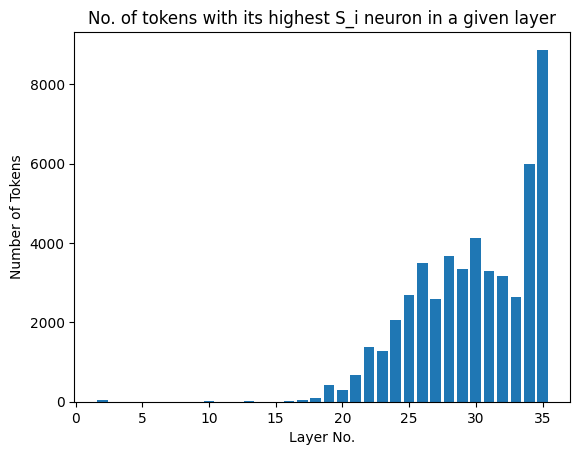

In [9]:
from collections import Counter
count = Counter(layers)
from matplotlib import pyplot as plt

plt.bar(count.keys(), count.values())
plt.title("No. of tokens with its highest S_i neuron in a given layer")
plt.xlabel("Layer No.")
plt.ylabel("Number of Tokens")

# Save the plot
plt.savefig("next_token_neurons_over_layers.png")
# Save as pdf
plt.savefig("next_token_neurons_over_layers.pdf")

In [56]:
print((count[31]+count[32]+count[33]+count[34]+count[35])/sum(count.values()))

0.4770081779652586


In [57]:
count

Counter({33: 2638,
         28: 3669,
         25: 2699,
         29: 3356,
         22: 1369,
         30: 4121,
         31: 3305,
         26: 3507,
         35: 8872,
         34: 5996,
         32: 3162,
         27: 2591,
         20: 303,
         19: 411,
         23: 1289,
         7: 1,
         24: 2066,
         2: 49,
         21: 661,
         10: 11,
         17: 51,
         13: 6,
         8: 3,
         18: 85,
         16: 26,
         9: 1,
         5: 3,
         15: 4,
         4: 2})

In [135]:
with open("./data/neuron_finder_results.json", "r") as f:
    neurons_json = json.load(f)

In [14]:
with open("neuron_finder_results.json", "w") as f:
    json.dump(results, f)